## Defensive Capacity

#### Load data & packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/Users/luisalawson/Downloads/Sample Data/epl.csv', delimiter=';')

### General grouping of data into dfs

In [3]:
df_prop = pd.DataFrame({
    'column_name': df.columns,
    'data_type': df.dtypes.values
})

In [4]:
df_vals = pd.DataFrame({
    'column_name': df.columns,
    'column_values': [set(df[col].tolist()) for col in df.columns],
    'unique_value_count': [len(set(df[col].tolist())) for col in df.columns]
})

### Define team_id: team_name dictionary

In [5]:
teams1 = df['home_team_name'].unique()
teams2 = df['away_team_name'].unique()

teams = set(teams2) | set(teams2)

In [6]:
team_id_name_dict = {}

In [8]:
for team in teams:
    team_id = df[df['home_team_name'] == team]['team_id'].values[0]
    team_id_name_dict[team_id] = team

### Set relevant events

In [10]:
one_defensive_events = ['Interception', 'Save', 'Ball recovery', 'Error', 'Offside provoked', 'Shield ball opp']
cero_defensive_events = ['Challenge']
binary_defensive_events = ['Take on', 'Foul', 'Tackle', 'Clearance', 'Aerial']

In [11]:
defensive_events = {
    'Interception': {'successful':1},
    'Save': {'successful':1},
    'Ball recovery': {'successful':1},
    'Error': {'successful':1},
    'Offside provoked': {'successful':1},
    'Shield ball opp': {'successful':1},
    'Challenge': {'unsuccessful':0},
    'Take on': {'successful':1, 'unsuccessful':0},
    'Foul': {'successful':1, 'unsuccessful':0},
    'Tackle': {'successful':1, 'unsuccessful':0},
    'Clearance': {'successful':1, 'unsuccessful':0},
    'Aerial': {'successful':1, 'unsuccessful':0},
}

In [12]:
dangerous_first_half = (0,30)
dangerous_second_half = (70,100)

### Player event collection

In [13]:
player_stats = []
player_names = df['playerName'].unique()

In [14]:
for player_name in player_names:
    if player_name == 'nan' or player_name == 'NaN':
        pass
    else:
        # for faster results
        player_df = df[df['playerName'] == player_name]
        
        if not player_df.empty:
            # gather team and start assigning position
            team_id = player_df['team_id'].iloc[0] if not player_df['team_id'].empty else None
            position = None

            # look for a valid position --> substitute considered not valid
            for pos in player_df['playerPosition']:
                if pos.lower() != 'substitute':  
                    position = pos
                    break  # when found stop
            stats = {
                'player_name': player_name,
                'team_id': team_id,
                'position': position,
            }

            total_defensive_events = 0
            successful_defensive_events = 0

            for event, outcomes in defensive_events.items():
                total_event_count = player_df[player_df['description'] == event].shape[0]
                stats[f'total_{event.lower().replace(" ", "_")}'] = total_event_count
                total_defensive_events += total_event_count

                if 'successful' in outcomes:
                    successful_event_count = player_df[(player_df['description'] == event) & (player_df['outcome'] == outcomes['successful'])].shape[0]
                    stats[f'successful_{event.lower().replace(" ", "_")}'] = successful_event_count
                    successful_defensive_events += successful_event_count

                for outcome_name, outcome_value in outcomes.items():
                    if outcome_name != 'successful':
                        outcome_event_count = player_df[(player_df['description'] == event) & (player_df['outcome'] == outcome_value)].shape[0]
                        stats[f'{outcome_name}_{event.lower().replace(" ", "_")}'] = outcome_event_count

            stats['defensive_capacity'] = successful_defensive_events / total_defensive_events if total_defensive_events > 0 else 0

            player_stats.append(stats)

In [15]:
df_players = pd.DataFrame(player_stats)

In [16]:
df_players

,player_name,team_id,position,total_interception,successful_interception,total_save,successful_save,total_ball_recovery,successful_ball_recovery,total_error,...,total_tackle,successful_tackle,unsuccessful_tackle,total_clearance,successful_clearance,unsuccessful_clearance,total_aerial,successful_aerial,unsuccessful_aerial,defensive_capacity
0,"Podolski, Lukas",3,Striker,15,15,2,2,68,68,3,...,32,25,7,23,10,13,77,25,52,0.578014
1,"Cazorla, Santiago",3,Midfielder,69,69,1,1,247,247,0,...,71,55,16,18,8,10,18,7,11,0.790235
2,"Vermaelen, Thomas",3,Defender,47,47,19,19,89,89,6,...,43,35,8,139,85,54,121,67,54,0.728814
3,"Walcott, Theo",3,Midfielder,11,11,0,0,89,89,0,...,16,15,1,5,0,5,25,7,18,0.787129
4,"Sessegnon, Stephane",56,Midfielder,11,11,2,2,97,97,1,...,20,17,3,7,3,4,80,17,63,0.671348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518,"Ibe, Jordon",14,Midfielder,1,1,0,0,8,8,0,...,1,1,0,0,0,0,0,0,0,0.909091
519,"Knott, Billy",56,None,0,0,0,0,2,2,0,...,0,0,0,0,0,0,1,0,1,0.666667
520,"Mitchell, Adam",56,None,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
521,"Fyvie, Fraser",111,None,1,1,0,0,2,2,0,...,1,1,0,0,0,0,0,0,0,1.000000


In [17]:
df_sorted = (df_players[df_players['position'].notna()]).sort_values(by='defensive_capacity', ascending=False)

In [18]:
df_sorted_no_gk = df_sorted[df_sorted['position']!='Goalkeeper']

In [19]:
team_dfs = {}

In [26]:
for team_id in df_sorted['team_id'].unique():
    team_dfs[team_id] = df_sorted[df_sorted['team_id'] == team_id].copy()
    team_dfs[team_id]['team_name'] = team_dfs[team_id]['team_id'].map(team_id_name_dict)


In [27]:
team_dfs.keys()

dict_keys([np.int64(3), np.int64(8), np.int64(108), np.int64(11), np.int64(45), np.int64(14), np.int64(35), np.int64(6), np.int64(1), np.int64(80), np.int64(54), np.int64(21), np.int64(20), np.int64(111), np.int64(52), np.int64(4), np.int64(110), np.int64(56), np.int64(43), np.int64(7)])

In [29]:
team_dfs[1][['player_name', 'team_name','position', 'defensive_capacity']]

,player_name,team_name,position,defensive_capacity
345,"Lindegaard, Anders",Manchester United,Goalkeeper,1.000000
36,"de Gea, David",Manchester United,Goalkeeper,0.986395
51,"Young, Ashley",Manchester United,Midfielder,0.815789
46,"Carrick, Michael",Manchester United,Midfielder,0.792248
53,"Oliveira, Anderson",Manchester United,Midfielder,0.779528
48,"Kagawa, Shinji",Manchester United,Midfielder,0.771242
294,"Giggs, Ryan",Manchester United,Midfielder,0.766082
47,"Cleverley, Tom",Manchester United,Midfielder,0.752174
443,"Jones, Phil",Manchester United,Defender,0.748148
344,"Ferdinand, Rio",Manchester United,Defender,0.741533


### Analysis on team 3

In [12]:
defenders_sums = {}
midfielders_sums = {}
strikers_sums = {}

for event, outcome in defensive_events.items():
    if 'successful' in outcome:
        event_rename = 'successful_' + event.lower().replace(" ", "_")
        position_sums = df_players.groupby('position')[event_rename].sum()

        defenders_sums[event] = position_sums.get('Defender', 0)
        midfielders_sums[event] = position_sums.get('Midfielder', 0)
        strikers_sums[event] = position_sums.get('Striker', 0)
        

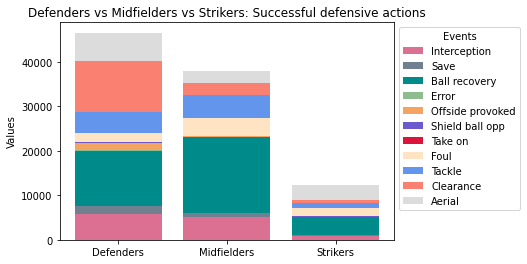

In [19]:
positions = ['Defenders', 'Midfielders', 'Strikers']

cumulative_sums = np.zeros(len(positions))

color_scheme = {
    'Ball recovery': 'darkcyan',
    'Interception': 'palevioletred',
    'Clearance': 'salmon',
    'Tackle': 'cornflowerblue',
    'Save': 'slategrey',
    'Error': 'darkseagreen',
    'Offside provoked': 'sandybrown',
    'Shield ball opp': 'slateblue',
    'Take on': 'crimson',
    'Foul': 'bisque',
    'Aerial': 'gainsboro'
}

fig, ax = plt.subplots()

for event, outcome in defensive_events.items():
    if 'successful' in outcome:
        event_values = np.array([defenders_sums[event], midfielders_sums[event], strikers_sums[event]])
        ax.bar(positions, event_values, bottom=cumulative_sums, label=event, color=color_scheme.get(event, 'gray'))
        cumulative_sums += event_values

ax.set_ylabel('Values')
ax.set_title('Defenders vs Midfielders vs Strikers: Successful defensive actions')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Events")

plt.show()